# SHRED for Parametric MSFR-ULOFF: outcore flux measures
This notebook implements the SHRED architecture for generating a parametric Reduced Order Model (ROM) of the Molten Salt Fast Reactor (MSFR) during an accidental scenario named ULOFF (Unprotected Loss of Fuel Flow).

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

path_snaps = '../../NuSHRED_Datasets/D2/'
path_svd = 'OfflineSVD/'
idx_params, params, var_names, is_vector, fom_times, rescaling_snaps, Nmodes = pickle.load(open(path_svd+'msfr_p.uloff', 'rb'))

## Compute Measures
The SHRED architecture takes as input 3 sensor measures and maps them to the reduced space characterizing the MSFR-ULOFF scenario. The sensor are placed outside the core and measure the total flux $\Phi$
\begin{equation*}
y^\Phi_m = v_m (\Phi)\cdot(1+ \epsilon_m), \quad m = 1, 2, 3
\end{equation*}
where $v_m$ is a functional describing the sensor procedure (either point-wise or Gaussian averaged) and $\epsilon_m$ is a Gaussian noise with standard deviation $\sigma$.

Let us import the snapshots at first.

In [2]:
measured_field = 3

# Import Snaps - in compression format
u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{var_names[measured_field]}.svd', 'rb'))
s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{var_names[measured_field]}.svd', 'rb'))
vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[var_names[measured_field]]

measured_snaps = dict()
for key in idx_params.keys():
    measured_snaps[key] = np.asarray([ (u_data @ s_data @ vh_data[ii].T).T 
                                      for ii in idx_params[key]])

del u_data, s_data, vh_data # free memory

Let us load the mesh

In [3]:
nodes = pickle.load(open(path_snaps+'domain.pkl', 'rb'))

Let us select the cells where the sensors can be placed

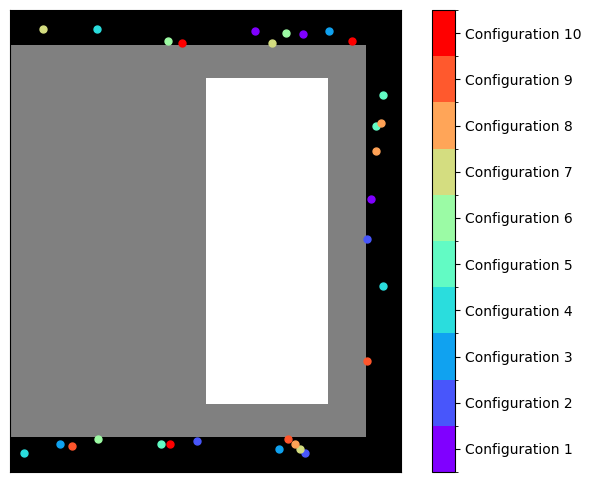

In [4]:
def is_out_core(node):
    return ((node[1] <= -1.13 and node[1] >= -1.23) or 
            (node[1] >=  1.13 and node[1] <=  1.23)) or (node[0] >= 2.05 and node[0] <= 2.15)

out_core = np.array([is_out_core(node) for node in nodes])
out_core_idx = np.where(out_core)[0]
in_core_idx  = np.where(~out_core)[0]

# Sampling the sensors locations
num_sensors = 3

n_configurations = 10
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)

np.random.seed(8) # set seed for reproducibility
for kk in range(n_configurations):
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(out_core_idx, size=num_sensors, replace=False), dtype=int)

# Plotting the sensors locations
from plots import get_msfr_geometry
import matplotlib.colors as mcolors

fig, axs = plt.subplots(figsize=(8,6))
get_msfr_geometry(axs)

cmap = cm.rainbow
colors = cmap(np.linspace(0,1,n_configurations))
for kk in range(n_configurations):
    axs.scatter(nodes[idx_sensor_locations[:, kk], 0], nodes[idx_sensor_locations[:, kk], 1], 
                color = colors[kk], s=25, label=f'Configuration {kk+1}')

# Create a discrete colormap and normalization
bounds = np.linspace(1, n_configurations+1, n_configurations+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the discrete colorbar to the plot
midpoints = (bounds[:-1] + bounds[1:]) / 2
cbar = plt.colorbar(sm, ax=axs, ticks=np.arange(n_configurations + 1))
cbar.ax.set_yticks(midpoints)
cbar.ax.set_yticklabels([f'Configuration {i}' for i in np.hstack([np.array([1]), np.arange(2, n_configurations + 1, 1, dtype=int)])])

plt.show()

Let us now extract the sensor measures from the snapshots

In [5]:
snap_measurements = list()

for kk in range(n_configurations):

    snap_measurements.append({
        key: measured_snaps[key][:, :, idx_sensor_locations[:,kk]]
        for key in list(measured_snaps.keys())
    })

del measured_snaps

Let us add uncorrelated Gaussian noise to the measures

In [6]:
noise_value = 0.005
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] * (1+np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape))
        for key in list(snap_measurements[kk].keys())
    })


print('Sensors Shape')
print(Xsensor[0]['train'].shape)
print(Xsensor[0]['test'].shape)
print(Xsensor[0]['valid'].shape)

Sensors Shape
(15, 600, 3)
(3, 600, 3)
(3, 600, 3)


Let us scale them to be in the range $[0, 1]$

In [7]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

Plotting some measures for a trajectory of the training set

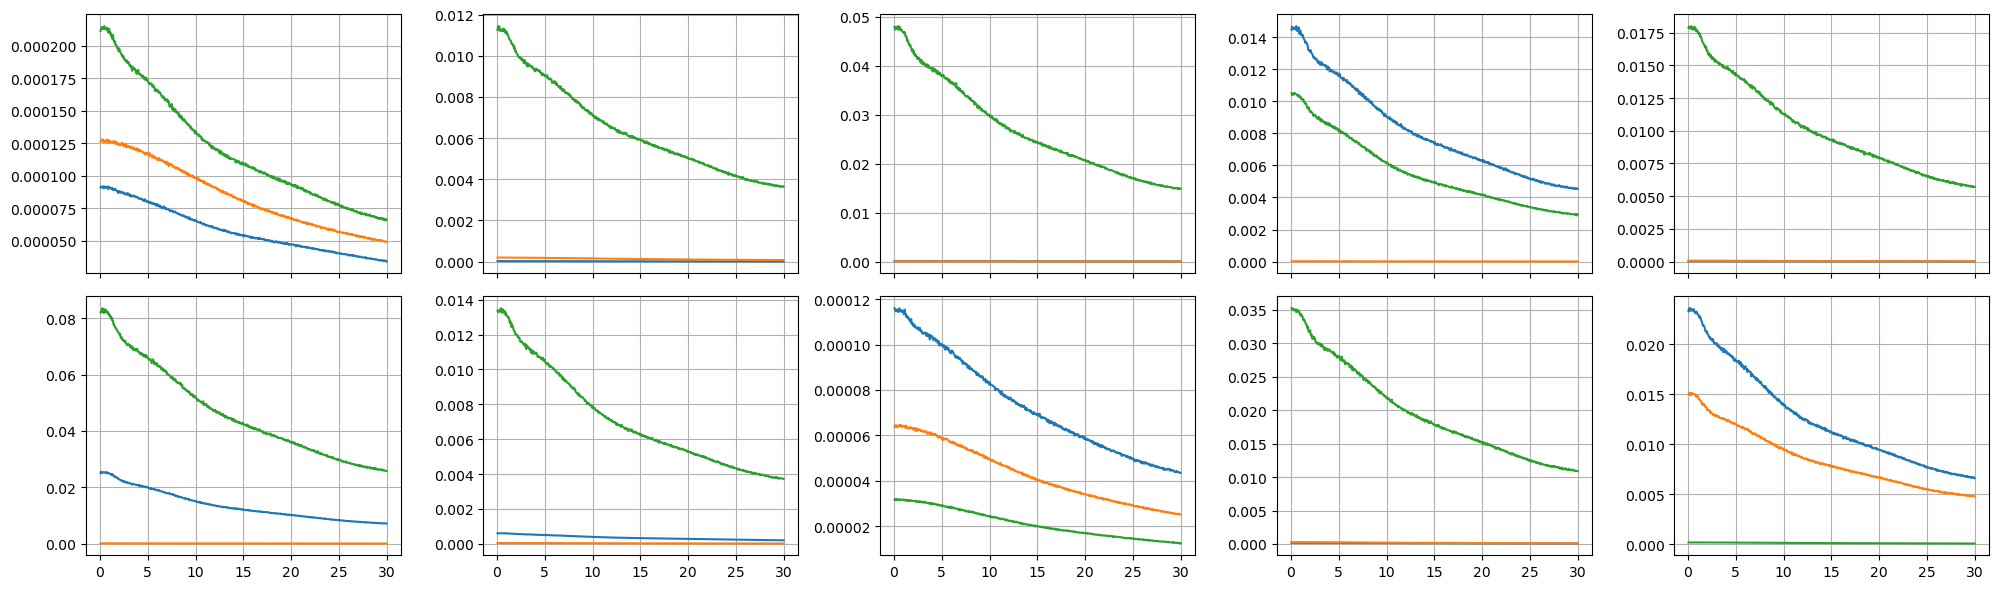

In [8]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (4 * ncols, 3 * nrows))
axs = axs.flatten()

param_to_plot = 3

for kk in range(nrows * ncols):
    axs[kk].plot(fom_times, Xsensor[kk]['train'][param_to_plot])
    axs[kk].grid()
    
plt.tight_layout()

## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [9]:
v_POD = pickle.load(open(path_svd+'v_POD.svd', 'rb'))

assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us create the parameters data

In [10]:
mu = np.zeros((params.shape[0], len(fom_times), params.shape[1]))
for idx in range(params.shape[0]):
    mu[idx] = params[idx]

parameters = {
    key : mu[idx_params[key]]
    for key in list(idx_params.keys())
}

Nparams = params.shape[1]
param_scaler = MinMaxScaler()
param_scaler.fit(parameters['train'].reshape(-1, Nparams))

rescaled_parameters = {
    key: param_scaler.transform(parameters[key].reshape(-1, Nparams)).reshape(parameters[key].shape)
    for key in list(parameters.keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(15, 600, 1)
(3, 600, 1)
(3, 600, 1)
POD Coeff Shape
(15, 600, 220)
(3, 600, 220)
(3, 600, 220)


Then, let us prepare them for the SHRED architecture

In [ ]:
import sys
sys.path.append('../../')

from shred.processdata import Padding, TimeSeriesDataset
import torch

# GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 20

# Input Data
train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags).to(device) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags).to(device) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags).to(device)  for kk in range(n_configurations)]

# Output Data
train_data_out = [Padding(torch.cat((torch.from_numpy(rescaled_v_POD['train']), 
                                     torch.from_numpy(rescaled_parameters['train'])), 
                                     axis=2), 1).squeeze(1).to(device)
                                     for kk in range(n_configurations)]

valid_data_out = [Padding(torch.cat((torch.from_numpy(rescaled_v_POD['valid']), 
                                     torch.from_numpy(rescaled_parameters['valid'])), 
                                     axis=2), 1).squeeze(1).to(device)
                                     for kk in range(n_configurations)]

test_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['test']), 
                                     torch.from_numpy(rescaled_parameters['test'])), 
                                     axis=2), 1).squeeze(1).to(device)

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out[kk]) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out[kk]) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]


## SHRED
Let us train the SHRED models for each configuration

In [14]:
from shred.models import SHRED, fit
import os

path_shred = './SHRED/'
os.makedirs(path_shred, exist_ok=True)

train_net = False

shred = list()
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, sum(Nmodes) + Nparams, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))

    if train_net:
        print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 3000, lr = 1e-3, verbose = True, patience = 50)

        torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred')
        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred',
                                             map_location=device))
    

/var/folders/rq/_c546f811656mn_2__gt6l_00000gn/T/ipykernel_4636/1403283616.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shred[kk].load_state_dict(torch.load(path_shr

Checking the test errors on the POD coefficients

In [15]:
path_test = './Test_results/'
os.makedirs(path_test, exist_ok=True)

pickle.dump(test_dataset, open(path_test+'test_dataset.pkl', 'wb'))

from shred.processdata import num2p, mre

[_shred.freeze() for _shred in shred]

Ytest_POD_hat = torch.stack([shred[kk](test_data_in[kk]) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0)
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,
                                                                            Ytest_POD_pred['mean'])))
print("Std  relative SHRED prediction error on POD coeffs: %s." % num2p((Ytest_POD_pred['std'].pow(2).sum(axis = -1).sqrt() / (test_data_out).pow(2).sum(axis = -1).sqrt()).mean()))

Mean relative SHRED prediction error on POD coeffs: 2.91%.
Std  relative SHRED prediction error on POD coeffs: 2.66%.


Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [16]:
reshaped_test_out = test_data_out.cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes) + Nparams)

reshaped_POD_test_out = {
    'mean': Ytest_POD_pred['mean'].cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes) + Nparams),
    'std':  Ytest_POD_pred['std'].cpu().detach().numpy().reshape(len(idx_params['test']), len(fom_times), sum(Nmodes) + Nparams)
}

Let us plot the error for each output of the SHRED

<BarContainer object of 221 artists>

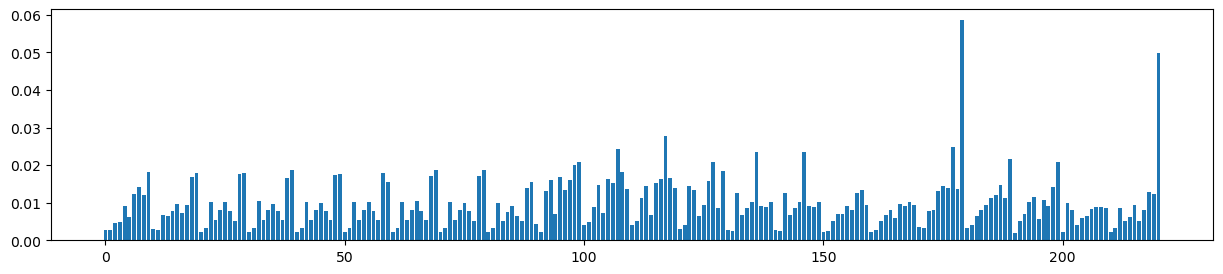

In [17]:
errors_pod_coeffs = [np.mean(np.abs(reshaped_test_out[:, :, pp] - reshaped_POD_test_out['mean'][:, :, pp]), axis=(0,1)) for pp in range(reshaped_test_out.shape[2])]

fig, axs = plt.subplots(1, 1, figsize=(15, 3))

axs.bar(np.arange(sum(Nmodes) + Nparams), errors_pod_coeffs)

Let us define the variables in LaTeX format for plotting

In [18]:
tex_var_names = [r'\mathbf{u}', 'T', '\Phi']
energy_groups = 6
tex_var_names.extend([r'\phi_'+str(g+1) for g in range(energy_groups)])

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

tex_var_names.extend(['p', r'p_{\text{rgh}}', r'\kappa', r'\nu_t', "q'''"])

assert len(tex_var_names) == len(var_names)

Comparison plots of the POD coefficients

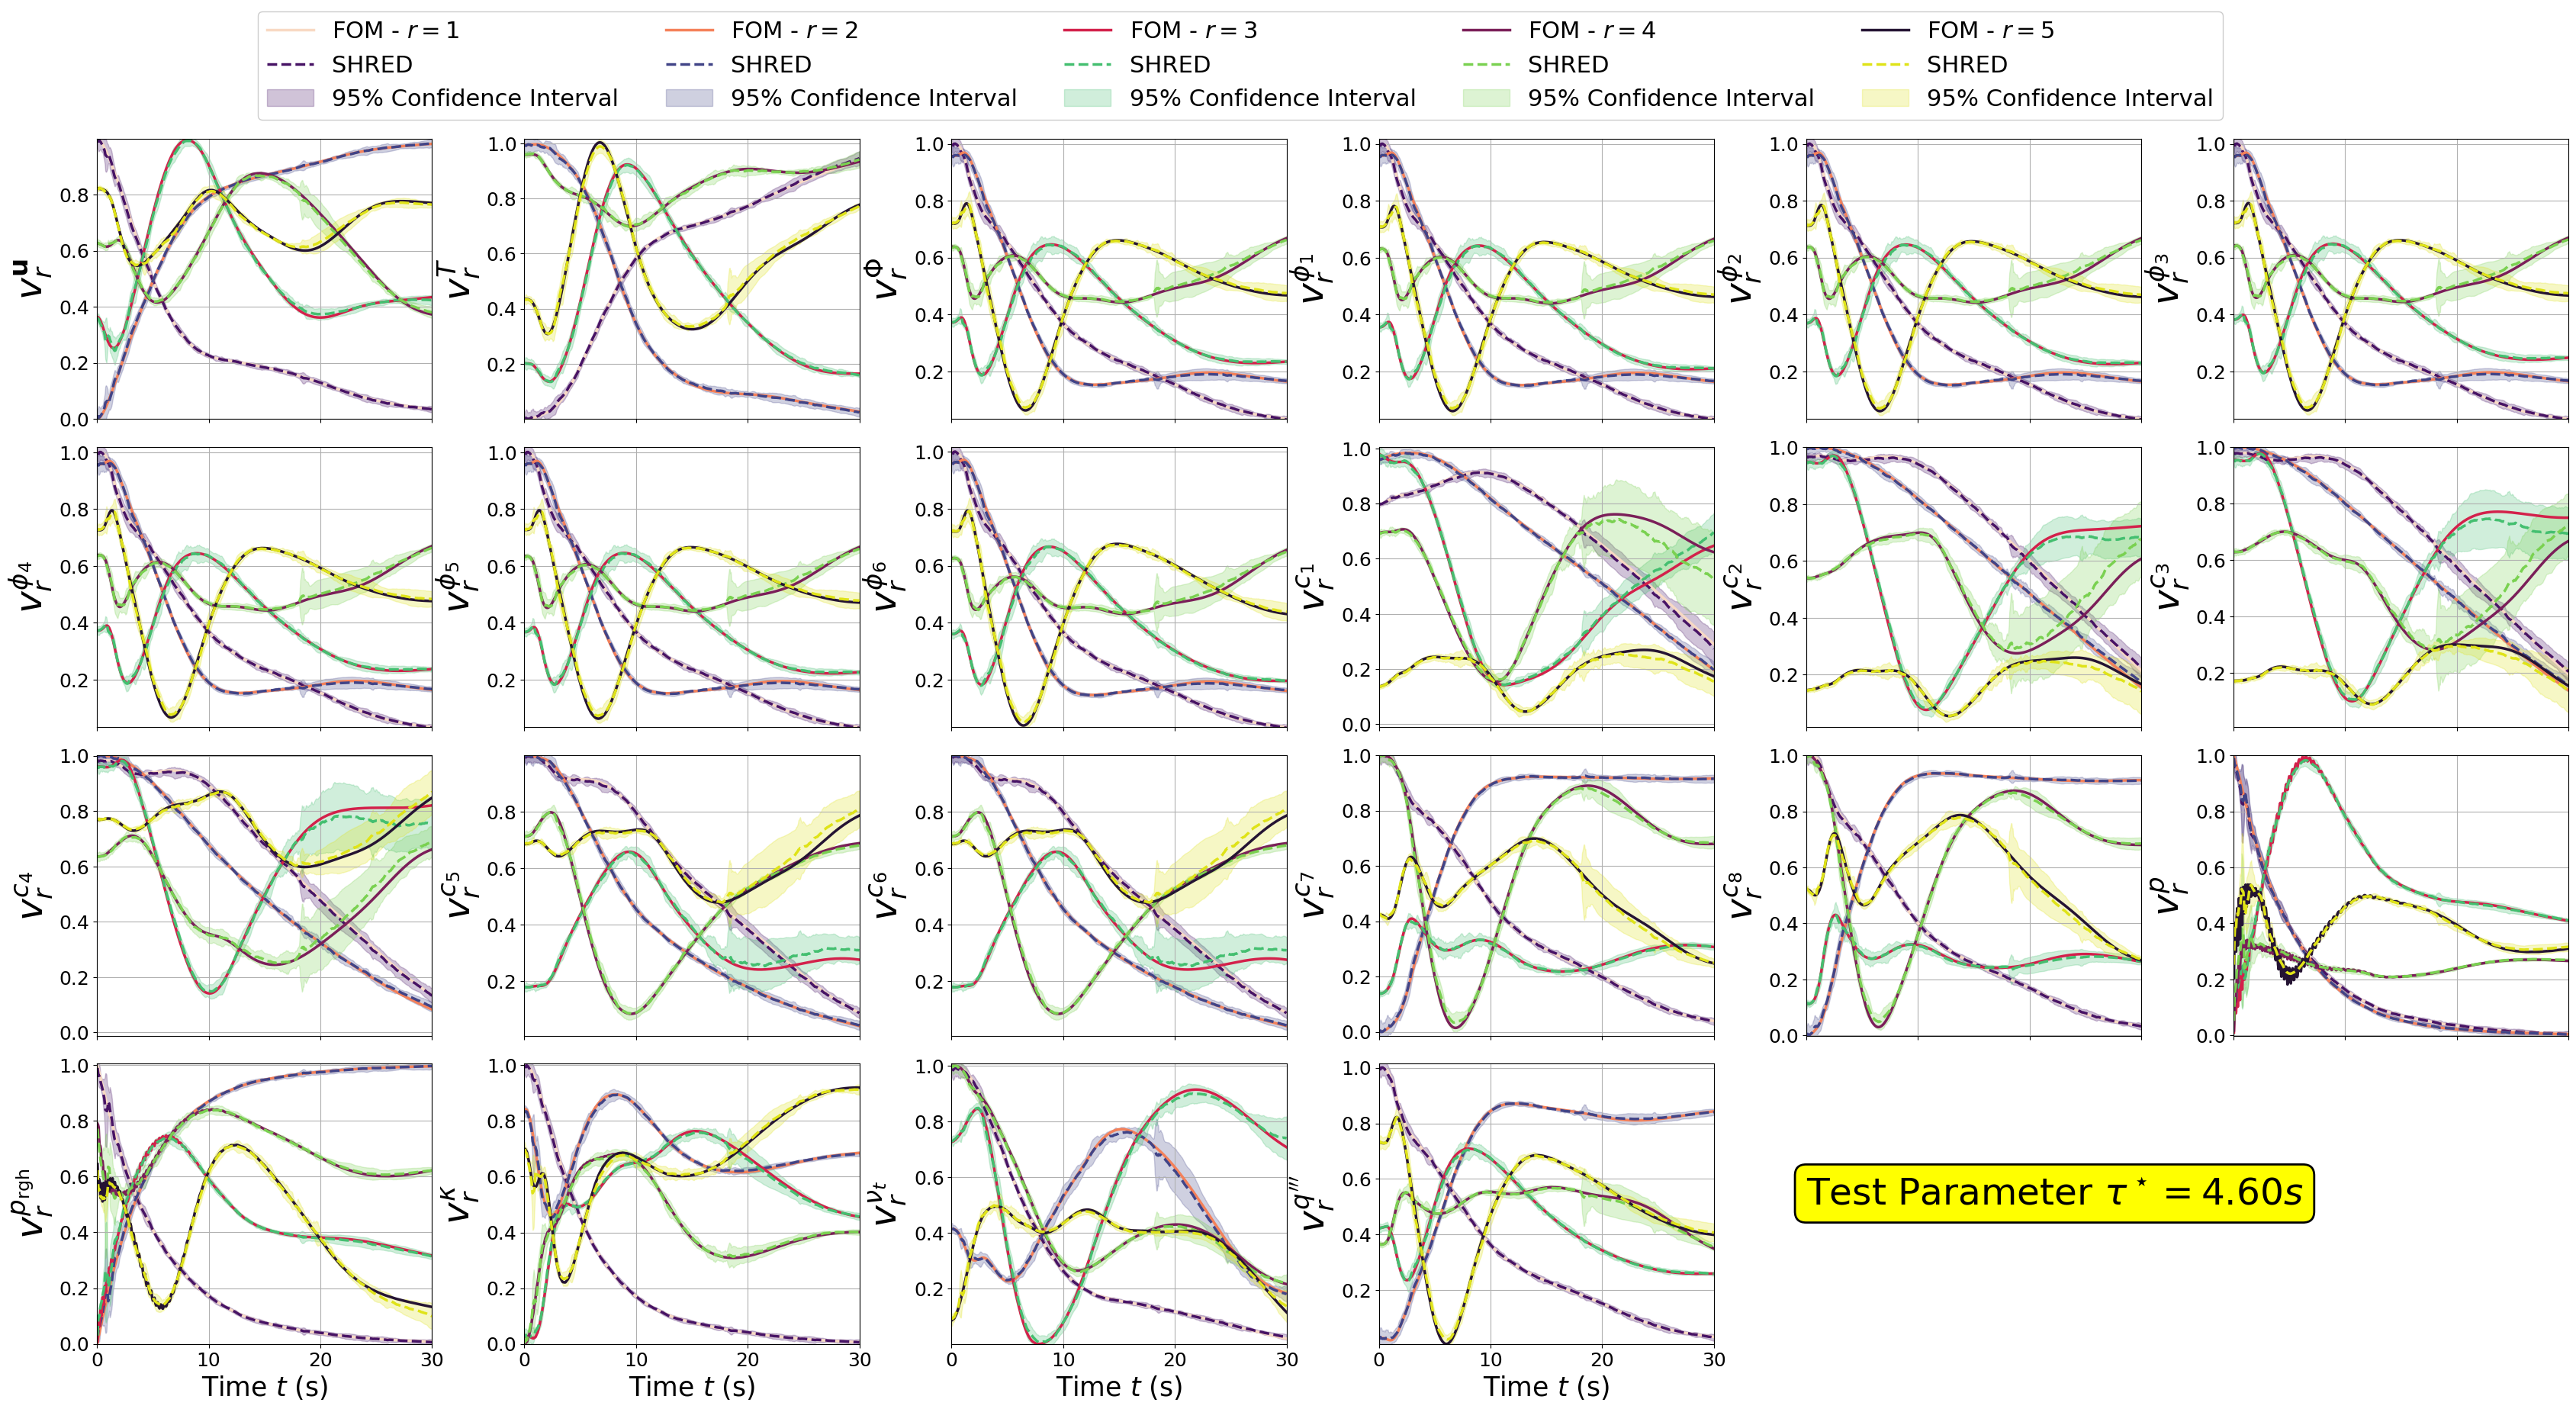

In [19]:
modes_to_plot = 5
param_to_plot = 0

nrows = 4
ncols = 6
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize=(6 * ncols, 5 * nrows))
axs = axs.flatten()

ls = 2.5

for field_i, field in enumerate(var_names):

    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    # colors = cm.jet([0.05, 0.2, 0.7, 0.8, 0.95])
    # colors_gt = cm.plasma(np.linspace(0.1,0.95,len(idx_to_plot)))

    colors = cm.viridis([0.05, 0.2, 0.7, 0.8, 0.95])
    colors_gt = sns.color_palette("rocket", as_cmap=True)(np.linspace(0.1,0.95,len(idx_to_plot)))
    for ii, idx in enumerate(idx_to_plot):
        axs[field_i].plot(fom_times, reshaped_test_out[param_to_plot,:,idx],
                          '-', linewidth=ls, c=colors_gt[-1-ii], label=r'FOM - $r='+str(ii+1)+'$')
        axs[field_i].plot(fom_times, reshaped_POD_test_out['mean'][param_to_plot,:,idx],
                          '--', c=colors[ii], label=r'SHRED', linewidth=ls)
        axs[field_i].fill_between(fom_times,
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    color=colors[ii], alpha=0.25, label=r'95% Confidence Interval')

    axs[field_i].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r'}$', fontsize=35)
    axs[field_i].grid()

    axs[field_i].set_ylim(reshaped_test_out[:,:,idx_to_plot].min(), 
                          reshaped_test_out[:,:,idx_to_plot].max())
    axs[field_i].set_xlim(0, fom_times[-1])
    axs[field_i].tick_params(axis='both', labelsize=18)
    
    # axs[field_i].set_xticks((np.array([0.5, 1.5, 2.5]) + new_t[-1] * np.arange(len(param_to_plot))[:, None]).flatten())
    # axs[field_i].set_xticklabels(np.hstack([[0.5, 1.5, 2.5] for _ in range(len(param_to_plot))]))

for field_i in range(len(var_names), nrows * ncols):
    axs[field_i].axis('off')

Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=22, ncols=5, framealpha=1, loc=(0.1, 0.915))

axs = axs.reshape(nrows, ncols)
axs[-1, -2].annotate(   r'Test Parameter $\tau^\star = {:.2f} s$'.format(params[idx_params['test'][param_to_plot],0]), 
                        xy=(0., .5), xycoords='axes fraction', fontsize=35, color='black',
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))

[ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

fig.subplots_adjust(left=0, hspace=0.1, top = 0.9, wspace=0.275)
fig.savefig(path_test+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compare the POD coefficients for the different values of $\tau$ for selected fields

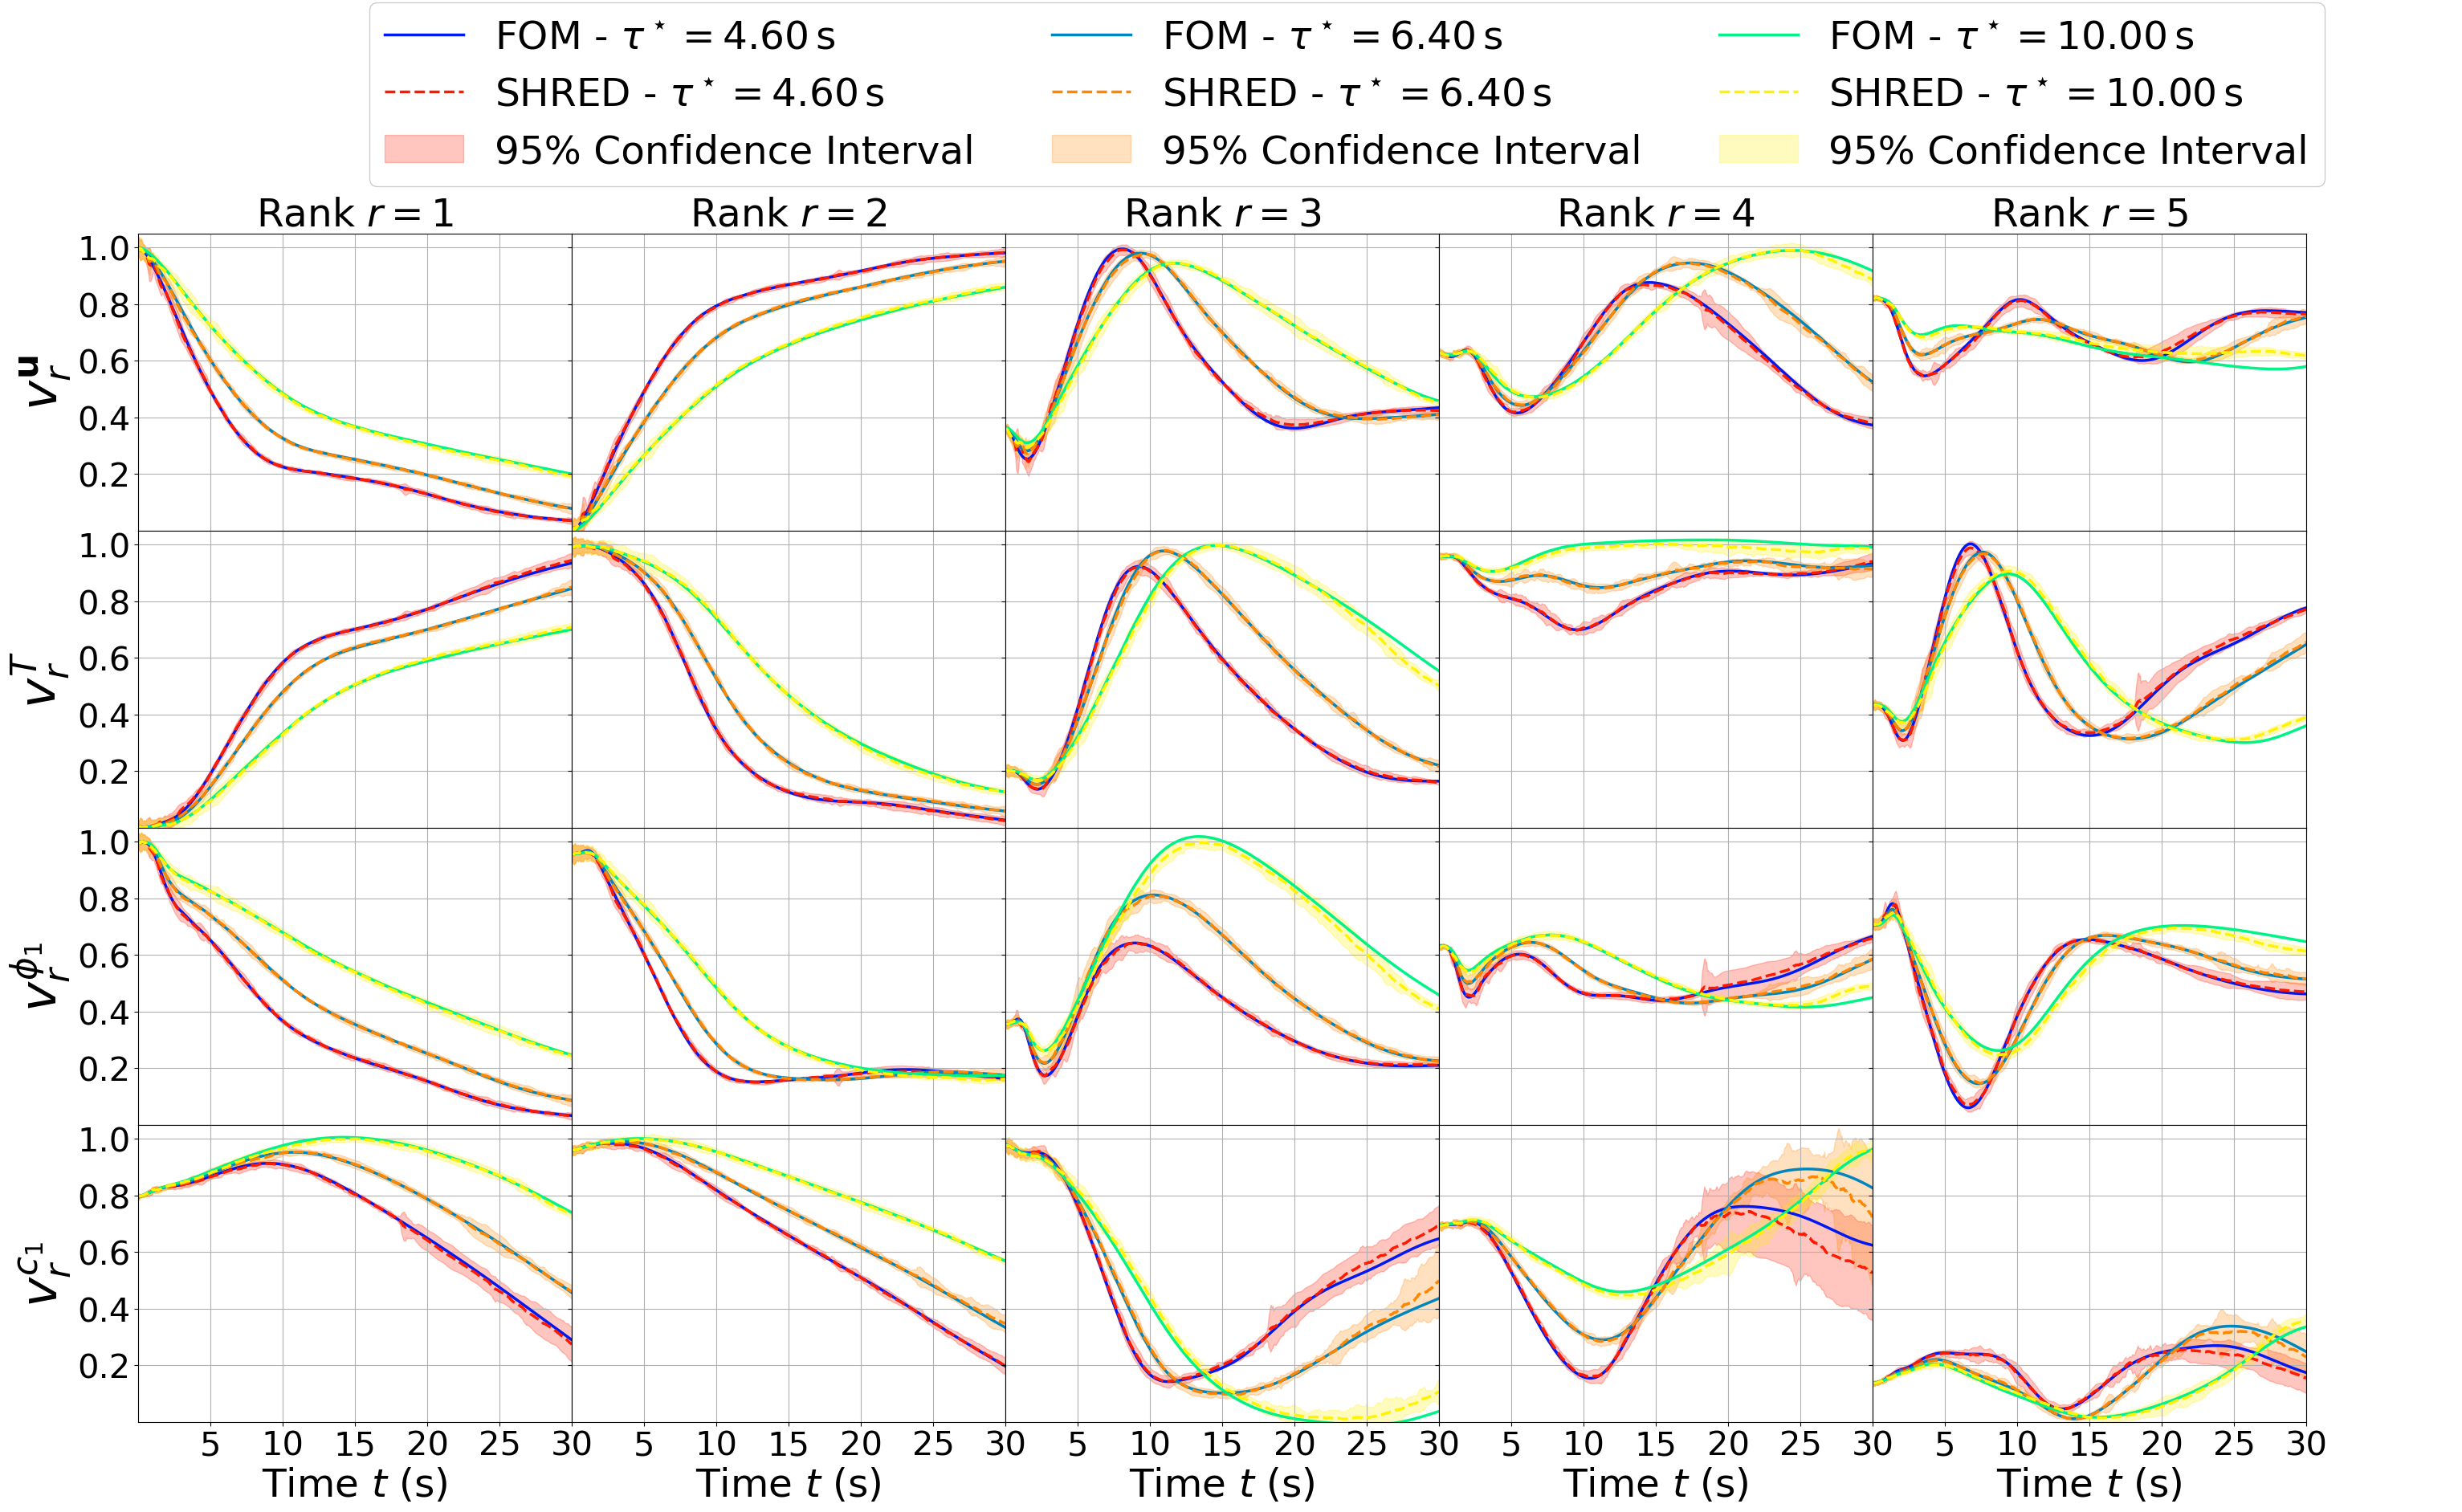

In [20]:
fields_idx_to_plot = [0,1,3,9]
modes_to_plot = 5

nrows = len(fields_idx_to_plot)
ncols = modes_to_plot

fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(6 * ncols, 5 * nrows))

ls = 2.5

for ii, field_i in enumerate(fields_idx_to_plot):
    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    colors = cm.autumn(np.linspace(0.1,0.95,len(idx_params['test'])))
    colors_gt = cm.winter(np.linspace(0.1,0.95,len(idx_params['test'])))

    for jj, idx in enumerate(idx_to_plot):
        for param_to_plot in range(len(idx_params['test'])):
            axs[ii, jj].plot(fom_times, reshaped_test_out[param_to_plot,:,idx],
                            '-', linewidth=ls, c=colors_gt[param_to_plot], label=r'FOM - $\tau^\star = {:.2f}\, \text{{s}}'.format(params[idx_params['test'][param_to_plot],0])+'$')
            axs[ii, jj].plot(fom_times, reshaped_POD_test_out['mean'][param_to_plot,:,idx],
                                '--', c=colors[param_to_plot], label=r'SHRED - $\tau^\star = {:.2f}\, \text{{s}}'.format(params[idx_params['test'][param_to_plot],0])+'$', linewidth=ls)
            axs[ii, jj].fill_between(fom_times,
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    color=colors[param_to_plot], alpha=0.25, label=r'95% Confidence Interval')
        axs[ii,jj].grid()
        axs[ii,jj].tick_params(axis='both', labelsize=30)
        axs[ii, jj].set_xlim(0, fom_times[-1])
        axs[ii, jj].set_ylim(0, 1.05)
        axs[ii, jj].set_xticks([5, 10, 15, 20, 25, 30])
        axs[ii, jj].set_yticks(np.arange(0.2, 1.01, 0.2))
    
[axs[0, jj].set_title(r'Rank $r='+str(jj+1)+'$', fontsize=35) for jj in range(ncols)]
[axs[ii, 0].set_ylabel(r'$v_r^{'+tex_var_names[fields_idx_to_plot[ii]]+r'}$', fontsize=45) for ii in range(nrows)]
[axs[-1, jj].set_xlabel(r'Time $t$ (s)', fontsize=35) for jj in range(ncols)]

Line, Label = axs[0,0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=35, ncols=3, framealpha=1, loc=(0.15, 0.8765))

fig.subplots_adjust(left=0, hspace=0.0, top = 0.85, wspace=0.)
fig.savefig(path_test+'SHRED_dynamics_test_parameters.pdf', format='pdf', dpi=10, bbox_inches='tight')
# fig.savefig(path_test+'SHRED_dynamics_test_parameters.png', format='png', dpi=150, bbox_inches='tight')

### Decoding to High-Dimensional Space
Let us decode the output of the SHRED models to the high-dimensional space.

The error is computed using the Euclidian norm

In [40]:
from tqdm import tqdm
from IPython.display import clear_output as clc

ave_rel_errors = {
    'mean': np.zeros((len(var_names), len(idx_params['test']), len(fom_times))),
    'std' : np.zeros((len(var_names), len(idx_params['test']), len(fom_times)))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    # Load compressed dataset
    u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{field}.svd', 'rb'))
    s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{field}.svd', 'rb'))
    vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[field]

    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = u_data @ s_data @ vh_data[idx_params['test'][param_to_recon]].T

        u_svd = pickle.load(open(path_svd+'pod_basis_'+field+'.svd', 'rb'))
        s_svd = pickle.load(open(path_svd+'sing_vals_'+field+'.svd', 'rb'))

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'][:,:,:-1].shape)
        _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'][:,:,:-1].shape) - vpod_scaler.data_min_

        recon     = u_svd @ np.diag(s_svd) @ _tmp_mean_v[param_to_recon, :, idx_to_rec]
        std_recon = u_svd @ np.diag(s_svd) @ _tmp_std_v[ param_to_recon, :, idx_to_rec]

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

        del fom, recon, std_recon
    del u_data, s_data, vh_data
    clc()

Let us plot the errors using bar plots

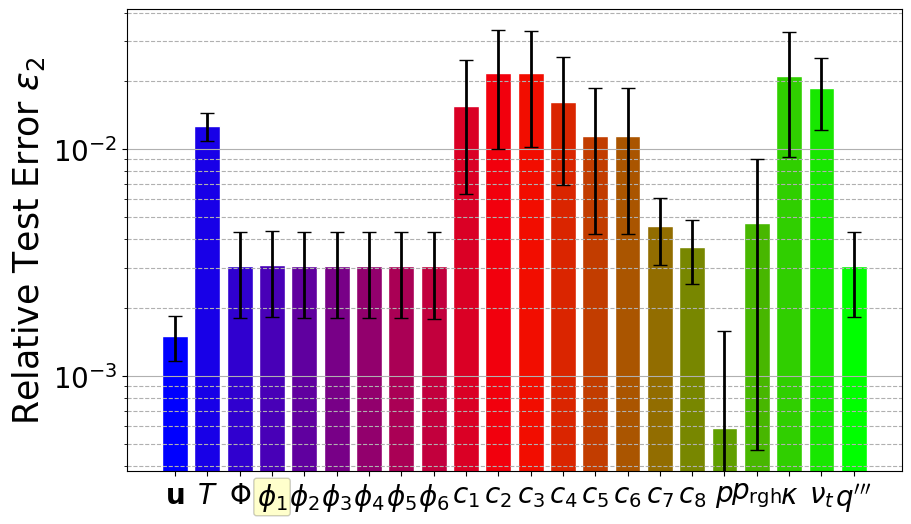

In [45]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,6))

colors = cm.brg(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].mean(axis=1).std(axis=1), capsize=5,
        color = colors,
        edgecolor='white',error_kw={'elinewidth': 2, 'ecolor': 'black', 'capsize': 5})

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

# Highlight the tick label at xtick = 4
xticks = axs.get_xticklabels()
xticks[3].set_color('black')  # Adjust index 3 (Python indexing starts at 0)
# Add a box around tick label at xtick = 3
xticks[3].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.2))

fig.savefig(path_test+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compute also some average quantities

In [49]:
vars_to_compare = [1,3,9,19]

fom_average = dict()
shred_average = dict()
shred_std = dict()

def get_average(u, s, vh):
    _ave = np.zeros((len(u), vh[0].shape[1]))

    for pp in range(len(u)):
        _ave_modes = np.mean(u[pp], axis=0).reshape(1,-1)
        _ave[pp] = np.linalg.multi_dot([_ave_modes, np.diag(s[pp]), vh[pp]])
    return _ave

for ii in range(len(vars_to_compare)):
    field = var_names[vars_to_compare[ii]]

    # FOM
    u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{field}.svd', 'rb'))
    s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{field}.svd', 'rb'))
    vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[field]

    fom_average[field] = np.zeros((len(idx_params['test']), len(fom_times)))
    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = u_data @ s_data @ vh_data[idx_params['test'][param_to_recon]].T
        fom_average[field][param_to_recon] = np.mean(rescaling_snaps[vars_to_compare[ii]].inverse_transform(fom), axis=0)

    # SHRED
    idx_to_rec = np.arange(sum(Nmodes[:vars_to_compare[ii]]),  sum(Nmodes[:vars_to_compare[ii]+1]),  1, dtype=int)

    u_svd = pickle.load(open(path_svd+'pod_basis_'+field+'.svd', 'rb'))
    s_svd = pickle.load(open(path_svd+'sing_vals_'+field+'.svd', 'rb'))

    _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'][:,:,:-1].shape)
    _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'][:,:,:-1].shape) - vpod_scaler.data_min_

    shred_average[field] = np.zeros((len(idx_params['test']), len(fom_times)))
    shred_std[field]     = np.zeros((len(idx_params['test']), len(fom_times)))

    for pp in range(len(idx_params['test'])):
        shred_average[field][pp] = np.mean(rescaling_snaps[vars_to_compare[ii]].inverse_transform(
            u_svd @ np.diag(s_svd) @ _tmp_mean_v[pp, :, idx_to_rec]
        ), axis=0)

        shred_std[field][pp] = np.mean(rescaling_snaps[vars_to_compare[ii]].inverse_std_transform(
            u_svd @ np.diag(s_svd) @ _tmp_std_v[pp, :, idx_to_rec]
        ), axis=0)

    del u_data, s_data, vh_data, u_svd, s_svd


Computing error for k: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Now let us plot them

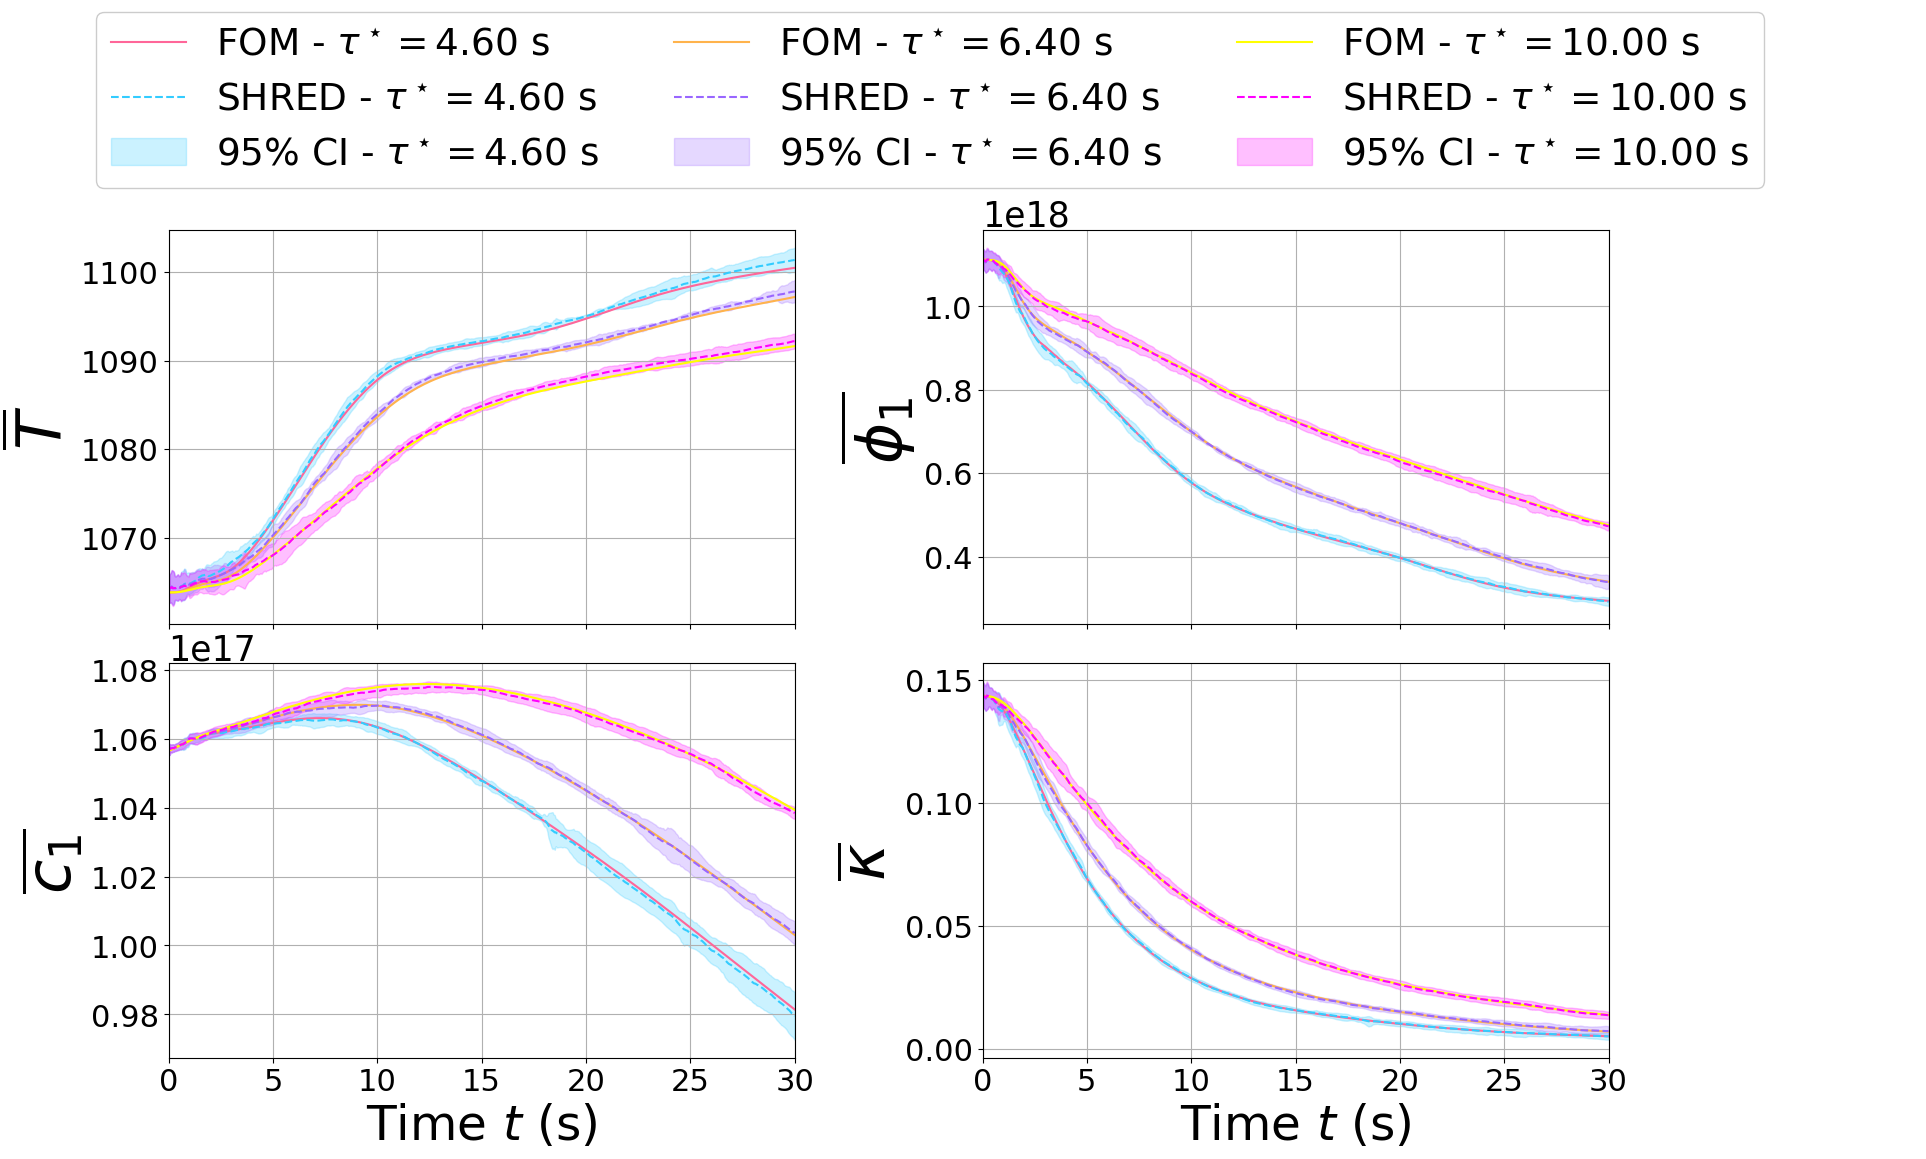

In [55]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, 
                        figsize=(8 * 2, 6 * 2))
axs = axs.flatten()

colors = cm.spring(np.linspace(0.4, 1, len(idx_params['test'])))
colors_shred = cm.cool(np.linspace(0.2, 1, len(idx_params['test'])))

for ii in range(len(vars_to_compare)):
    field = var_names[vars_to_compare[ii]]

    for pp in range(len(idx_params['test'])):
        axs[ii].plot(fom_times, fom_average[field][pp], label=r'FOM - $\tau^\star = {:.2f}$ s'.format(params[idx_params['test'][pp],0]), color=colors[pp])
        axs[ii].plot(fom_times, shred_average[field][pp], '--', label=r'SHRED - $\tau^\star = {:.2f}$ s'.format(params[idx_params['test'][pp],0]), color=colors_shred[pp])
        axs[ii].fill_between(fom_times,
                                    y1 = shred_average[field][pp] - 1.96 * shred_std[field][pp],
                                    y2 = shred_average[field][pp] + 1.96 * shred_std[field][pp],
                                    color=colors_shred[pp], alpha=0.25,
                                    label=r'95% CI - $\tau^\star = {:.2f}$ s'.format(params[idx_params['test'][pp],0]))

    axs[ii].set_xlim(0, fom_times[-1])
    axs[ii].set_ylabel(r"$\overline{{"+tex_var_names[vars_to_compare[ii]]+r"}}$", fontsize=45)
    if ii >= 2:
        axs[ii].set_xlabel(r'Time $t$ (s)', fontsize=35)
    # axs[ii].set_xlabel(r'Time $t$ (s)', fontsize=35)

    axs[ii].grid()
    axs[ii].tick_params(axis='both', labelsize=22)
    axs[ii].set_xticks([0, 5, 10, 15, 20, 25, 30])

    # Increase the size of the scientific notation multiplier (e.g., x10^15)
    axs[ii].yaxis.get_offset_text().set_fontsize(25)  # Adjust this value as needed

Line, Label = axs[0].get_legend_handles_labels()

fig.legend(Line, Label, fontsize=27, ncols=3, framealpha=1, loc=(0.05, 0.8375))
fig.subplots_adjust(left=0, wspace=0.3, top = 0.8, hspace=0.1)
fig.savefig(path_test+'fom_shred_QoIcomparison.pdf', format='pdf', dpi=150, bbox_inches='tight')


### Contour Plots
In the end, some contour plots are shown to visualize the reconstruction in the high-dimensional space.

In [62]:
from plots import plot_contour, create_streamlines

cmaps = [
    cm.RdYlBu_r,
    sns.color_palette("icefire", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.color_palette("cubehelix", as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.cubehelix_palette(as_cmap=True),
    sns.color_palette("mako", as_cmap=True),
    sns.color_palette("mako", as_cmap=True),
    sns.color_palette("Blues", as_cmap=True),
    sns.color_palette("YlOrBr", as_cmap=True),
    cm.jet,
]

Let us select the field and the parameter to plot

In [88]:
field_i = 3 # 0, 1, 3
field = var_names[field_i]
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

param_to_plot = 0

u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{field}.svd', 'rb'))
s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{field}.svd', 'rb'))
vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[field]

fom = rescaling_snaps[field_i].inverse_transform(u_data @ s_data @ vh_data[idx_params['test'][param_to_plot]].T)

Let us reconstruct the field

In [89]:
u_svd = pickle.load(open(path_svd+'pod_basis_'+field+'.svd', 'rb'))
s_svd = pickle.load(open(path_svd+'sing_vals_'+field+'.svd', 'rb'))

_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'][:,:,:-1].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'][:,:,:-1].shape)
_tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'][:,:,:-1].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'][:,:,:-1].shape) - vpod_scaler.data_min_

recon = rescaling_snaps[field_i].inverse_transform(
    u_svd @ np.diag(s_svd) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]
)

std_recon = rescaling_snaps[field_i].inverse_std_transform(
    u_svd @ np.diag(s_svd) @ _tmp_std_v[param_to_plot, :, idx_to_rec]
)

Here, the plots for videos are generated

In [90]:
import matplotlib.ticker as mticker
        
path_fig = path_test+'Figs/Param_{:.2f}'.format(params[idx_params['test'][param_to_plot],0])+'/'+field+'/'
os.makedirs(path_fig, exist_ok=True)

vec_mode_to_plot = 'Mag' if field_i == 0 else None
streamline_plot = True if field_i == 0 else False

# Add titles
if vec_mode_to_plot is not None:
    _var = r'$\|'+tex_var_names[field_i]+'\|_2$'
else:
    _var = r'$'+tex_var_names[field_i]+'$'

ncols = 2

resid = np.abs(fom - recon)

for time_to_plot in tqdm(np.arange(19, len(fom_times), 20)):

    vec_mode_to_plot = 'Mag' if field_i == 0 else None
    streamline_plot = True if field_i == 0 else False

    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4), dpi=250)
    levels = np.linspace(0,1.5,100) if vec_mode_to_plot is not None else np.linspace(fom.min(), fom.max(), 200)

    # FOM plot
    fom_contour = plot_contour(axs[0], nodes, fom[:, time_to_plot], cmap=cmaps[field_i],
                               streamline_plot = streamline_plot,
                            vec_mode_to_plot=vec_mode_to_plot, levels=levels)

    # Reconstruction plot
    recon_contour = plot_contour(axs[1], nodes, recon[:, time_to_plot], cmap=cmaps[field_i],
                               streamline_plot = streamline_plot,
                                vec_mode_to_plot=vec_mode_to_plot, levels=levels)

    # Residual plot
    if ncols > 2:
        resid_contour = plot_contour(axs[2], nodes, resid[:, time_to_plot],
                                    vec_mode_to_plot=vec_mode_to_plot, cmap=cm.hot, levels=30)
        cbar_res = fig.colorbar(resid_contour,
                                ax=axs[2], orientation='vertical', pad=0.05, aspect=20, shrink = 0.75)
        cbar_res.ax.tick_params(labelsize=12)

        cbar_res.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        axs[2].set_title(r'Residual - '+_var, fontsize=20)

    fig.subplots_adjust(wspace=0.05)

    # Add colorbars
    cbar_fom = fig.colorbar(fom_contour, 
                            ax=axs[:2], orientation='horizontal', pad=0.05, aspect=20, shrink = 0.85)
    cbar_fom.ax.tick_params(labelsize=10)
  
    # cbar_fom.ax.set_yticks(np.linspace(levels[0], levels[-1], 10))

    # Add titles
    if vec_mode_to_plot is not None:
        _var = r'$\|'+tex_var_names[field_i]+'\|_2$'
    else:
        _var = r'$'+tex_var_names[field_i]+'$'

    axs[0].set_title(r'FOM - '+_var, fontsize=20)
    axs[1].set_title(r'SHRED - '+_var, fontsize=20)

    if ncols > 2:
        axs[-1].annotate(    r'Time $t={:.2f}$'.format(fom_times[time_to_plot])+r's - Parameter $\tau = {:.2f} s$'.format(params[idx_params['test'][param_to_plot],0]),
                            xy=(-0.15, -0.1), xycoords='axes fraction', fontsize=15, color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))
    else:
        axs[-1].annotate(    r'Time $t={:.2f}$'.format(fom_times[time_to_plot])+r's',
                            xy=(-0.5, 1.1), xycoords='axes fraction', fontsize=10, color='black',
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow', lw=2))

    fig.savefig(path_fig+'FOM_vs_SHRED_{:.2f}'.format(fom_times[time_to_plot])+'.png', 
                format='png', dpi=250, bbox_inches='tight', transparent=True)
    plt.close(fig)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)
100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Make gifs

In [91]:
import imageio.v2 as imageio

# Create the GIF by loading each image and adding it to the array
def get_gif(gif_path, image_files, duration=150.):
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for img_file in image_files:
            img_path = os.path.join(path_fig, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

# Create the MP4 video by loading each image and adding it to the array
def get_video(video_path, image_files, fps=10):
    with imageio.get_writer(video_path, fps=fps, codec="libx264") as writer:
        for img_file in image_files:
            img_path = os.path.join(path_fig, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

image_files = sorted(os.listdir(path_fig), key=lambda x: int(x.split('_')[-1].split('.')[0]))

get_gif(path_test+'Figs/Param_{:.2f}/'.format(params[idx_params['test'][param_to_plot],0])+var_names[field_i]+'.gif', image_files, duration=200.)
get_video(path_test+'Figs/Param_{:.2f}/'.format(params[idx_params['test'][param_to_plot],0])+var_names[field_i]+'.mp4', image_files, fps=5)

os.makedirs('../../media/P2/', exist_ok=True)
os.system('mv '+path_test+'Figs/Param_{:.2f}/'.format(params[idx_params['test'][param_to_plot],0])+var_names[field_i]+'.gif ../../media/P2/'+var_names[field_i]+'.gif')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1434, 961) to (1440, 976) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


0